In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fr_util import getData

label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
X, Y = getData(balance_ones=True)

In [ ]:
# show some of these dang images
i = np.random.choice(7)
x, y = X[Y==i], Y[Y==i]
N = len(y)
j = np.random.choice(N)
plt.imshow(x[j].reshape(48, 48), cmap='gray')
plt.title(label_map[y[j]]);

# In Theano

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

from fr_util import getData, getBinaryData, error_rate, relu, init_weight_and_bias
from sklearn.utils import shuffle

In [2]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = theano.shared(W, 'W_%s' % self.id)
        self.b = theano.shared(b, 'b_%s' % self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return relu(X.dot(self.W) + self.b)


class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=10e-7, mu=0.99, decay=0.999, reg=10e-12, eps=10e-10, epochs=400, batch_sz=100, show_fig=False):
        learning_rate = np.float32(learning_rate)
        mu = np.float32(mu)
        decay = np.float32(decay)
        reg = np.float32(reg)
        eps = np.float32(eps)

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # for momentum
        dparams = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # set up theano functions and variables
        thX = T.fmatrix('X')
        thY = T.ivector('Y')
        pY = self.forward(thX)

        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.predict(thX)

        cost_predict_op = theano.function(inputs=[thX, thY], outputs=[cost, prediction])

        updates = [
            (c, decay*c + (np.float32(1)-decay)*T.grad(cost, p)*T.grad(cost, p)) for p, c in zip(self.params, cache)
        ] + [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        ]

        # momentum only
        # updates = [
        #     (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ] + [
        #     (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ]

        train_op = theano.function(
            inputs=[thX, thY],
            updates=updates
        )

        n_batches = N // batch_sz
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                train_op(Xbatch, Ybatch)

                if j % 20 == 0:
                    c, p = cost_predict_op(Xvalid, Yvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, p)
                    print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)

    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward(X)
        return T.argmax(pY, axis=1)


In [3]:
X, Y = getData()

i: 0 j: 0 nb: 392 cost: 1.9198087453842163 error rate: 0.779
i: 0 j: 20 nb: 392 cost: 1.9386857748031616 error rate: 0.774
i: 0 j: 40 nb: 392 cost: 1.907104253768921 error rate: 0.771
i: 0 j: 60 nb: 392 cost: 1.9748119115829468 error rate: 0.852
i: 0 j: 80 nb: 392 cost: 2.025104284286499 error rate: 0.835
i: 0 j: 100 nb: 392 cost: 1.994652271270752 error rate: 0.831
i: 0 j: 120 nb: 392 cost: 1.8822135925292969 error rate: 0.723
i: 0 j: 140 nb: 392 cost: 1.8878538608551025 error rate: 0.735
i: 0 j: 160 nb: 392 cost: 1.970933198928833 error rate: 0.818
i: 0 j: 180 nb: 392 cost: 1.844335913658142 error rate: 0.711
i: 0 j: 200 nb: 392 cost: 1.830924391746521 error rate: 0.714
i: 0 j: 220 nb: 392 cost: 1.880251407623291 error rate: 0.742
i: 0 j: 240 nb: 392 cost: 1.8093453645706177 error rate: 0.717
i: 0 j: 260 nb: 392 cost: 1.822540521621704 error rate: 0.701
i: 0 j: 280 nb: 392 cost: 1.8418055772781372 error rate: 0.735
i: 0 j: 300 nb: 392 cost: 1.796783685684204 error rate: 0.704
i: 0 j:

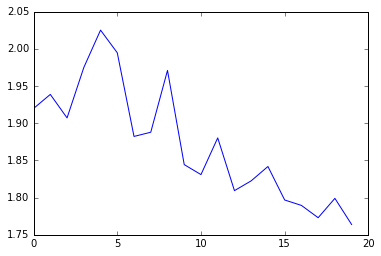

In [4]:
# X, Y = getBinaryData()
model = ANN([2000, 1000])
model.fit(X, Y, show_fig=True, epochs=1)